# 🔬 Quantization Mechanism Chain Verification
## DeepSeek-R1-Distill-Qwen-1.5B with AWQ/GPTQ 3-bit

**Adapted for Quantized-Reasoning-Models Project**

---

### Research Question

**Does the causal chain "Small Residual → Strong RMSNorm Reversal → Large Hidden → Large Quantization Error → Accuracy Degradation" hold for mathematical reasoning?**

### Hypothesis (Chang et al., 2025)

```
H1: Mathematical text has smaller residual magnitudes than general text
H2: Smaller residuals lead to stronger RMSNorm reversal effect
H3: Stronger reversal leads to larger post-RMSNorm hidden magnitudes
H4: Larger hidden magnitudes amplify quantization errors
H5: Higher quantization errors lead to greater accuracy degradation
```

### Experimental Design

| Component | Specification |
|-----------|---------------|
| Model | DeepSeek-R1-Distill-Qwen-1.5B |
| Quantization | AWQ-3bit, GPTQ-3bit, FP16 (baseline) |
| Domains | General (FineWeb), GSM8K, AIME/MATH |
| Samples | 500 per domain (mechanism), 300 (accuracy) |
| Statistics | Pearson/Spearman correlation, Bootstrap CI, Mediation analysis |

---

### Prerequisites

**Required quantized models** (must exist before running):

```bash
# AWQ 3-bit model
./outputs/modelzoo/awq/DeepSeek-R1-Distill-Qwen-1.5B-awq-w3g128-tp1/

# GPTQ 3-bit model
./outputs/modelzoo/gptq/DeepSeek-R1-Distill-Qwen-1.5B-gptq-w3g128-tp1/
```

If these models don't exist, generate them first:

```bash
# Generate AWQ 3-bit
bash scripts/quantization/awq.sh ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B 1 0

# Generate GPTQ 3-bit
bash scripts/quantization/gptq.sh ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B 1 0
```

---

### Key Modifications from Original

1. **No autoawq/auto-gptq dependency** - Uses transformers directly
2. **Pre-quantized models only** - No on-the-fly quantization
3. **Local model paths** - Uses project's existing quantized models
4. **Simplified setup** - Fewer dependencies, faster startup

---

## 0. Environment Setup

In [1]:
# Installation (run once)
# !pip install torch>=2.1.0 transformers>=4.40.0 accelerate>=0.27.0
# !pip install datasets>=2.18.0 scipy statsmodels pandas numpy matplotlib seaborn tqdm

# Note: autoawq and auto-gptq NOT needed - we use pre-quantized models from our project

In [2]:
import os
import sys
import json
import gc
import re
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, field, asdict
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# Statistics
from scipy import stats
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, kruskal, kurtosis
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation

# HuggingFace
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from datasets import load_dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 11,
    'figure.dpi': 150,
    'figure.figsize': (12, 8),
    'axes.titlesize': 12,
    'axes.labelsize': 11
})
warnings.filterwarnings('ignore')

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Python: 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:16:04) [GCC 11.2.0]
PyTorch: 2.5.1+cu124
CUDA Available: True
GPU: NVIDIA GeForce RTX 4070 SUPER
VRAM: 12.9 GB


In [3]:
@dataclass
class ExperimentConfig:
    """Experiment configuration with full documentation"""
    
    # Experiment metadata
    experiment_name: str = "MechanismChainVerification"
    version: str = "1.0.0"
    timestamp: str = field(default_factory=lambda: datetime.now().strftime("%Y%m%d_%H%M%S"))
    seed: int = 42
    output_dir: str = "./mechanism_chain_results"
    
    # Model configuration
    base_model: str = "./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B"
    
    # Quantization settings
    quant_bits: int = 3
    group_size: int = 128
    
    # Data configuration
    n_general: int = 500      # General domain samples
    n_gsm8k: int = 500        # GSM8K samples
    n_aime: int = 250         # AIME/MATH hard samples
    n_accuracy: int = 300     # Accuracy evaluation samples
    
    # Sequence configuration
    max_seq_length: int = 512
    min_seq_length: int = 64
    max_new_tokens: int = 512  # For generation
    
    # Statistical configuration
    bootstrap_n_resamples: int = 10000
    bootstrap_confidence_level: float = 0.95
    significance_level: float = 0.05
    
    # Hardware
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: torch.dtype = torch.float16
    batch_size: int = 8
    
    def __post_init__(self):
        os.makedirs(self.output_dir, exist_ok=True)
        self._set_seeds()
        self._save_config()
    
    def _set_seeds(self):
        """Set all random seeds for reproducibility"""
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    def _save_config(self):
        """Save configuration to JSON"""
        config_dict = {k: str(v) if isinstance(v, torch.dtype) else v 
                       for k, v in asdict(self).items()}
        with open(f"{self.output_dir}/config.json", 'w') as f:
            json.dump(config_dict, f, indent=2)

config = ExperimentConfig()
print(f"Experiment: {config.experiment_name} v{config.version}")
print(f"Output: {config.output_dir}")
print(f"Samples: General={config.n_general}, GSM8K={config.n_gsm8k}, AIME={config.n_aime}")

Experiment: MechanismChainVerification v1.0.0
Output: ./mechanism_chain_results
Samples: General=500, GSM8K=500, AIME=250


## 1. Data Preparation

In [4]:
class DataManager:
    """
    Manages data loading for mechanism analysis and accuracy evaluation.
    
    Domains:
    - General: FineWeb or C4 (non-mathematical text)
    - GSM8K: Grade school math problems
    - AIME: American Invitational Mathematics Examination (hard)
    """
    
    def __init__(self, tokenizer, config: ExperimentConfig):
        self.tokenizer = tokenizer
        self.config = config
        
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            tokenizer.pad_token_id = tokenizer.eos_token_id
    
    def _tokenize_with_length(self, text: str) -> Optional[Dict]:
        """
        Tokenize text and return with actual length info.
        Returns None if text is too short.
        """
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=self.config.max_seq_length,
            padding='max_length',
            return_attention_mask=True
        )
        
        # Calculate actual length (non-padding tokens)
        actual_length = tokens['attention_mask'].sum().item()
        
        if actual_length < self.config.min_seq_length:
            return None
        
        # IMPORTANT: Move tensors to CPU for storage to avoid device conflicts later
        return {
            'input_ids': tokens['input_ids'].cpu(),
            'attention_mask': tokens['attention_mask'].cpu(),
            'actual_length': actual_length
        }
    
    def _compute_numeric_density(self, text: str) -> float:
        """Compute fraction of tokens containing digits"""
        tokens = self.tokenizer.tokenize(text)
        if not tokens:
            return 0.0
        numeric_count = sum(1 for t in tokens if re.search(r'\d', t))
        return numeric_count / len(tokens)
    
    def load_general(self, n: int) -> List[Dict]:
        """Load general domain text from FineWeb or C4"""
        print(f"Loading General domain ({n} samples)...")
        
        try:
            ds = load_dataset("HuggingFaceFW/fineweb", 
                             name="sample-10BT", 
                             split="train", 
                             streaming=True)
            source = "FineWeb"
        except Exception as e:
            print(f"  FineWeb failed ({e}), falling back to C4...")
            ds = load_dataset("allenai/c4", "en", 
                             split="validation", 
                             streaming=True)
            source = "C4"
        
        samples = []
        pbar = tqdm(ds, total=n*3, desc=f"General ({source})")
        
        for item in pbar:
            text = item.get('text', '')
            
            # Filter: minimum length, not too numeric
            if len(text) < 200:
                continue
            
            numeric_density = self._compute_numeric_density(text[:500])
            if numeric_density > 0.3:  # Skip if too numeric
                continue
            
            result = self._tokenize_with_length(text)
            if result is None:
                continue
            
            samples.append({
                'text': text[:2000],
                'input_ids': result['input_ids'],
                'attention_mask': result['attention_mask'],
                'actual_length': result['actual_length'],
                'domain': 'general',
                'difficulty': 0,
                'numeric_density': numeric_density,
                'source': source
            })
            
            pbar.set_postfix({'collected': len(samples)})
            
            if len(samples) >= n:
                break
        
        print(f"  Loaded {len(samples)} samples")
        return samples
    
    def load_gsm8k(self, n: int, for_accuracy: bool = False) -> List[Dict]:
        """
        Load GSM8K math problems.
        
        Args:
            n: Number of samples
            for_accuracy: If True, return format for accuracy evaluation
        """
        print(f"Loading GSM8K ({n} samples, accuracy={for_accuracy})...")
        
        ds = load_dataset("gsm8k", "main", split="test")
        samples = []
        
        for item in tqdm(ds, desc="GSM8K"):
            question = item['question']
            answer_text = item['answer']
            
            # Extract numerical answer (after ####)
            match = re.search(r'####\s*(-?[\d,]+)', answer_text)
            if not match:
                continue
            gold_answer = match.group(1).replace(',', '')
            
            if for_accuracy:
                # Format for generation/accuracy evaluation
                prompt = f"""Solve this math problem step by step. Write your final numerical answer after ####.

Problem: {question}

Solution:"""
                samples.append({
                    'prompt': prompt,
                    'question': question,
                    'gold_answer': gold_answer,
                    'full_solution': answer_text,
                    'domain': 'gsm8k'
                })
            else:
                # Format for mechanism analysis (full text)
                text = f"Problem: {question}\n\nSolution: {answer_text}"
                result = self._tokenize_with_length(text)
                if result is None:
                    continue
                
                samples.append({
                    'text': text,
                    'input_ids': result['input_ids'],
                    'attention_mask': result['attention_mask'],
                    'actual_length': result['actual_length'],
                    'domain': 'gsm8k',
                    'difficulty': 1,
                    'numeric_density': self._compute_numeric_density(text),
                    'gold_answer': gold_answer
                })
            
            if len(samples) >= n:
                break
        
        print(f"  Loaded {len(samples)} samples")
        return samples
    
    def load_aime(self, n: int) -> List[Dict]:
        """Load AIME/MATH hard problems (difficulty level 4-5)"""
        print(f"Loading AIME/MATH hard ({n} samples)...")
        
        # Try multiple sources
        ds = None
        source = None
        
        for ds_name in ["AI-MO/aimo-validation-aime", 
                        "Maxwell-Jia/AIME_1983_2024",
                        "qq8933/AIME_1983_2024"]:
            try:
                ds = load_dataset(ds_name, split="train")
                source = ds_name
                print(f"  Using {ds_name}")
                break
            except:
                continue
        
        if ds is None:
            print("  AIME datasets unavailable, using MATH Level 4-5...")
            try:
                ds = load_dataset("lighteval/MATH", "all", split="test")
            except:
                ds = load_dataset("hendrycks/competition_math", split="test")
            source = "MATH"
        
        samples = []
        for item in tqdm(ds, desc=f"AIME ({source})"):
            # Filter by difficulty for MATH dataset
            if source == "MATH":
                level = item.get('level', '')
                if 'Level 4' not in level and 'Level 5' not in level:
                    continue
            
            # Extract problem and solution
            problem = item.get('problem', item.get('question', ''))
            solution = item.get('solution', item.get('answer', ''))
            
            if not problem:
                continue
            
            text = f"Problem: {problem}\n\nSolution: {solution}"
            result = self._tokenize_with_length(text)
            if result is None:
                continue
            
            samples.append({
                'text': text[:2000],
                'input_ids': result['input_ids'],
                'attention_mask': result['attention_mask'],
                'actual_length': result['actual_length'],
                'domain': 'aime',
                'difficulty': 2,
                'numeric_density': self._compute_numeric_density(text),
                'source': source
            })
            
            if len(samples) >= n:
                break
        
        print(f"  Loaded {len(samples)} samples")
        return samples
    
    def load_all_mechanism_data(self) -> List[Dict]:
        """Load all data for mechanism analysis"""
        all_samples = []
        
        all_samples.extend(self.load_general(self.config.n_general))
        all_samples.extend(self.load_gsm8k(self.config.n_gsm8k, for_accuracy=False))
        all_samples.extend(self.load_aime(self.config.n_aime))
        
        # Assign indices
        for i, sample in enumerate(all_samples):
            sample['idx'] = i
        
        print(f"\nTotal mechanism samples: {len(all_samples)}")
        print(f"  General: {sum(1 for s in all_samples if s['domain'] == 'general')}")
        print(f"  GSM8K: {sum(1 for s in all_samples if s['domain'] == 'gsm8k')}")
        print(f"  AIME: {sum(1 for s in all_samples if s['domain'] == 'aime')}")
        
        return all_samples
    
    def load_accuracy_data(self) -> List[Dict]:
        """Load data for accuracy evaluation"""
        return self.load_gsm8k(self.config.n_accuracy, for_accuracy=True)

## 2. Mechanism Analyzer (Chang et al. Implementation)

In [5]:
class MechanismAnalyzer:
    """
    Implements Chang et al. (2025) mechanism analysis.
    
    Measures at each layer l in upper half:
    - r^(l): Residual state (before RMSNorm) - Eq. 5
    - h^(l): Hidden state (after RMSNorm) - RMSNorm(r^(l))
    - norm(x; r^(l)): Residual magnitude - Eq. 7
    - norm(x; h^(l)): Hidden magnitude
    - κ^(l): Kurtosis (outlier measure)
    - reversal_ratio: ||h^(l)|| / ||r^(l)||
    
    References:
    - Chang et al. "Why Do Some Inputs Break Low-Bit LLM Quantization?" 2025
    """
    
    def __init__(self, model, tokenizer, config: ExperimentConfig):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        
        # Get model layers
        if hasattr(model, 'model') and hasattr(model.model, 'layers'):
            self.layers = model.model.layers
        elif hasattr(model, 'transformer') and hasattr(model.transformer, 'h'):
            self.layers = model.transformer.h
        else:
            raise ValueError("Cannot find model layers")
        
        self.num_layers = len(self.layers)
        # Analyze upper half layers (as in Chang et al.)
        self.analysis_layers = list(range(self.num_layers // 2, self.num_layers))
        
        # Hook storage
        self.hooks = []
        self.residual_states = {}  # r^(l)
        self.hidden_states = {}    # h^(l)
        
        print(f"MechanismAnalyzer initialized:")
        print(f"  Total layers: {self.num_layers}")
        print(f"  Analysis layers: {self.analysis_layers[0]}-{self.analysis_layers[-1]}")
    
    def _get_rmsnorm_module(self, layer):
        """Get the post-attention RMSNorm/LayerNorm module"""
        # Try different naming conventions
        for name in ['post_attention_layernorm', 'ln_2', 'post_ln']:
            if hasattr(layer, name):
                return getattr(layer, name)
        return None
    
    def _hook_capture_input(self, layer_idx: int):
        """Hook to capture RMSNorm input (r^(l))"""
        def hook(module, inp, out):
            if isinstance(inp, tuple):
                self.residual_states[layer_idx] = inp[0].detach()
            else:
                self.residual_states[layer_idx] = inp.detach()
        return hook
    
    def _hook_capture_output(self, layer_idx: int):
        """Hook to capture RMSNorm output (h^(l))"""
        def hook(module, inp, out):
            self.hidden_states[layer_idx] = out.detach()
        return hook
    
    def register_hooks(self):
        """Register forward hooks for mechanism analysis"""
        self.clear_hooks()
        
        for layer_idx in self.analysis_layers:
            layer = self.layers[layer_idx]
            rmsnorm = self._get_rmsnorm_module(layer)
            
            if rmsnorm is not None:
                # Capture input (r^(l)) and output (h^(l))
                h1 = rmsnorm.register_forward_hook(self._hook_capture_input(layer_idx))
                h2 = rmsnorm.register_forward_hook(self._hook_capture_output(layer_idx))
                self.hooks.extend([h1, h2])
        
        print(f"  Registered {len(self.hooks)} hooks")
    
    def clear_hooks(self):
        """Remove all hooks and clear stored states"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.residual_states = {}
        self.hidden_states = {}
    
    @torch.no_grad()
    def analyze_sample(self, sample: Dict) -> Dict:
        """
        Analyze mechanism variables for a single sample.
        
        Returns:
            Dict with all mechanism measurements
        """
        # Clear previous states
        self.residual_states = {}
        self.hidden_states = {}
        
        # Prepare inputs - ensure they're on the correct device
        input_ids = sample['input_ids'].to(self.config.device)
        attention_mask = sample['attention_mask'].to(self.config.device)
        actual_length = sample['actual_length']
        
        # Forward pass
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            use_cache=False
        )
        
        # Compute NLL
        logits = outputs.logits
        shift_logits = logits[:, :actual_length-1, :].contiguous()
        shift_labels = input_ids[:, 1:actual_length].contiguous()
        
        loss_fct = nn.CrossEntropyLoss(reduction='mean')
        nll = loss_fct(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).item()
        
        # Analyze layer-wise measurements
        layer_results = defaultdict(dict)
        
        for layer_idx in self.analysis_layers:
            r_mag, h_mag, reversal, kurt = 0, 0, 0, 0
            
            if layer_idx in self.residual_states:
                r = self.residual_states[layer_idx].float().squeeze(0)  # [T, d]
                r = r[:actual_length]  # Only actual tokens
                
                # norm(x; r^(l)) = (1/T) * Σ ||r_t||_2  (Eq. 7)
                r_norms = torch.norm(r, p=2, dim=-1)  # [T]
                r_mag = r_norms.mean().item()
                
                # Kurtosis (outlier measure)
                r_flat = r.flatten().cpu().numpy()
                try:
                    kurt = float(kurtosis(r_flat, fisher=True))
                except:
                    kurt = 0.0
            
            if layer_idx in self.hidden_states:
                h = self.hidden_states[layer_idx].float().squeeze(0)  # [T, d]
                h = h[:actual_length]
                
                # norm(x; h^(l))
                h_norms = torch.norm(h, p=2, dim=-1)
                h_mag = h_norms.mean().item()
                
                # Reversal ratio
                if r_mag > 0:
                    reversal = h_mag / r_mag
            
            layer_results[layer_idx] = {
                'residual_mag': r_mag,
                'hidden_mag': h_mag,
                'reversal_ratio': reversal,
                'kurtosis': kurt
            }
        
        # Aggregate across layers
        all_r_mags = [v['residual_mag'] for v in layer_results.values() if v['residual_mag'] > 0]
        all_h_mags = [v['hidden_mag'] for v in layer_results.values() if v['hidden_mag'] > 0]
        all_reversals = [v['reversal_ratio'] for v in layer_results.values() if v['reversal_ratio'] > 0]
        all_kurts = [v['kurtosis'] for v in layer_results.values()]
        
        # Last layer values (most predictive per Chang et al.)
        last_layer = max(self.analysis_layers)
        last_results = layer_results.get(last_layer, {})
        
        return {
            'nll': nll,
            # Aggregated (mean over upper layers)
            'avg_residual_mag': np.mean(all_r_mags) if all_r_mags else 0,
            'avg_hidden_mag': np.mean(all_h_mags) if all_h_mags else 0,
            'avg_reversal_ratio': np.mean(all_reversals) if all_reversals else 0,
            'avg_kurtosis': np.mean(all_kurts) if all_kurts else 0,
            # Last layer (strongest signal)
            'last_residual_mag': last_results.get('residual_mag', 0),
            'last_hidden_mag': last_results.get('hidden_mag', 0),
            'last_reversal_ratio': last_results.get('reversal_ratio', 0),
            'last_kurtosis': last_results.get('kurtosis', 0),
            # Per-layer data (for detailed analysis)
            'layer_results': dict(layer_results)
        }
    
    @torch.no_grad()
    def compute_nll_only(self, sample: Dict) -> float:
        """Compute only NLL (faster, no hooks needed)"""
        # Ensure tensors are on correct device, handling both Tensor and nested dict cases
        if isinstance(sample['input_ids'], torch.Tensor):
            input_ids = sample['input_ids'].to(self.config.device)
            attention_mask = sample['attention_mask'].to(self.config.device)
        else:
            # Handle case where sample might have been modified
            input_ids = torch.tensor(sample['input_ids']).to(self.config.device)
            attention_mask = torch.tensor(sample['attention_mask']).to(self.config.device)
        
        actual_length = sample['actual_length']
        
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            use_cache=False
        )
        
        logits = outputs.logits
        shift_logits = logits[:, :actual_length-1, :].contiguous()
        shift_labels = input_ids[:, 1:actual_length].contiguous()
        
        loss = nn.CrossEntropyLoss(reduction='mean')(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )
        
        return loss.item()

## 3. Accuracy Evaluator

In [6]:
class AccuracyEvaluator:
    """
    Evaluates mathematical reasoning accuracy on GSM8K.
    
    Uses greedy decoding to generate solutions and extracts
    numerical answers for comparison.
    """
    
    def __init__(self, model, tokenizer, config: ExperimentConfig):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
    
    def _extract_answer(self, text: str) -> Optional[str]:
        """
        Extract numerical answer from generated text.
        Priority: #### marker > "answer is" > last number
        """
        # Pattern 1: #### marker (GSM8K format)
        match = re.search(r'####\s*(-?[\d,]+\.?\d*)', text)
        if match:
            return match.group(1).replace(',', '')
        
        # Pattern 2: "answer is" phrase
        match = re.search(r'answer\s+is\s*:?\s*(-?[\d,]+\.?\d*)', text, re.IGNORECASE)
        if match:
            return match.group(1).replace(',', '')
        
        # Pattern 3: "= X" at end of sentence
        match = re.search(r'=\s*(-?[\d,]+\.?\d*)\s*[.\n]', text)
        if match:
            return match.group(1).replace(',', '')
        
        # Pattern 4: Last number in text
        numbers = re.findall(r'-?\d+\.?\d*', text)
        if numbers:
            return numbers[-1]
        
        return None
    
    def _normalize_answer(self, answer: Optional[str]) -> str:
        """Normalize answer for comparison"""
        if answer is None:
            return ""
        
        # Remove commas, whitespace
        answer = answer.replace(',', '').strip()
        
        # Handle decimals (round to int if .0)
        try:
            num = float(answer)
            if num == int(num):
                return str(int(num))
            return str(num)
        except:
            return answer
    
    @torch.no_grad()
    def evaluate_single(self, problem: Dict) -> Dict:
        """
        Evaluate a single problem.
        
        Returns dict with:
            - predicted: extracted answer
            - gold: correct answer
            - correct: boolean
            - response: generated text (truncated)
        """
        prompt = problem['prompt']
        gold = self._normalize_answer(problem['gold_answer'])
        
        # Tokenize
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=self.config.max_seq_length
        ).to(self.config.device)
        
        try:
            # Generate
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=self.config.max_new_tokens,
                do_sample=False,  # Greedy decoding for reproducibility
                temperature=None,
                top_p=None,
                pad_token_id=self.tokenizer.pad_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )
            
            # Decode
            full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            response = full_response[len(prompt):].strip()
            
        except Exception as e:
            return {
                'predicted': None,
                'gold': gold,
                'correct': False,
                'response': f"ERROR: {str(e)}",
                'error': True
            }
        
        # Extract and compare
        extracted = self._extract_answer(response)
        predicted = self._normalize_answer(extracted)
        correct = (predicted == gold)
        
        return {
            'predicted': predicted,
            'gold': gold,
            'correct': correct,
            'response': response[:1000],  # Truncate for storage
            'error': False
        }
    
    def evaluate_batch(self, problems: List[Dict], desc: str = "Evaluating") -> Dict:
        """
        Evaluate a batch of problems.
        
        Returns:
            accuracy: float
            correct_count: int
            total: int
            details: list of individual results
        """
        results = []
        correct_count = 0
        total = len(problems)
        
        print(f"\n{desc}: Starting evaluation of {total} problems...")
        
        for i, problem in enumerate(problems):
            result = self.evaluate_single(problem)
            results.append(result)
            
            if result['correct']:
                correct_count += 1
            
            # Print progress every 10 problems
            if (i + 1) % 10 == 0 or (i + 1) == total:
                current_acc = correct_count / (i + 1)
                print(f"  Progress: {i+1}/{total} ({(i+1)/total*100:.1f}%) | "
                      f"Correct: {correct_count}/{i+1} | "
                      f"Accuracy: {current_acc:.2%}")
            
            # Memory management
            if len(results) % 20 == 0:
                torch.cuda.empty_cache()
        
        accuracy = correct_count / total if total else 0
        
        print(f"✓ {desc} Complete: {correct_count}/{total} correct ({accuracy:.2%})\n")
        
        return {
            'accuracy': accuracy,
            'correct_count': correct_count,
            'total': total,
            'details': results
        }

## 4. Quantization Manager

In [7]:
class QuantizationManager:
    """
    Manages model loading with different quantization methods.
    
    Supports:
    - FP16: No quantization (baseline)
    - AWQ: Pre-quantized AWQ models from our project
    - GPTQ: Pre-quantized GPTQ models from our project
    """
    
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.current_model = None
        self.current_tokenizer = None
        self.current_method = None
    
    def _clear_model(self):
        """Clear current model from memory"""
        if self.current_model is not None:
            del self.current_model
            self.current_model = None
        if self.current_tokenizer is not None:
            del self.current_tokenizer
            self.current_tokenizer = None
        gc.collect()
        torch.cuda.empty_cache()
    
    def load_fp16(self) -> Tuple[Any, Any]:
        """
        Load model in FP16 (baseline).
        """
        print(f"\nLoading FP16 model: {self.config.base_model}")
        self._clear_model()
        
        tokenizer = AutoTokenizer.from_pretrained(
            self.config.base_model,
            trust_remote_code=True
        )
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            self.config.base_model,
            torch_dtype=self.config.dtype,
            device_map="auto",
            trust_remote_code=True
        )
        model.eval()
        
        self.current_model = model
        self.current_tokenizer = tokenizer
        self.current_method = "FP16"
        
        print(f"  Loaded successfully")
        return model, tokenizer
    
    def load_awq(self, model_path: str) -> Tuple[Any, Any]:
        """
        Load pre-quantized AWQ model from our project.
        
        Args:
            model_path: Path to pre-quantized AWQ model (e.g., ./outputs/modelzoo/awq/...)
        """
        print(f"\nLoading AWQ model from: {model_path}")
        self._clear_model()
        
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"AWQ model not found at {model_path}")
        
        # Load using standard transformers (our models are in HF format)
        tokenizer = AutoTokenizer.from_pretrained(
            model_path,
            trust_remote_code=True
        )
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=self.config.dtype,
            device_map="auto",
            trust_remote_code=True
        )
        model.eval()
        
        self.current_model = model
        self.current_tokenizer = tokenizer
        self.current_method = f"AWQ-{self.config.quant_bits}bit"
        
        print(f"  Loaded successfully")
        return model, tokenizer
    
    def load_gptq(self, model_path: str) -> Tuple[Any, Any]:
        """
        Load pre-quantized GPTQ model from our project.
        
        Args:
            model_path: Path to pre-quantized GPTQ model (e.g., ./outputs/modelzoo/gptq/...)
        """
        print(f"\nLoading GPTQ model from: {model_path}")
        self._clear_model()
        
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"GPTQ model not found at {model_path}")
        
        # Load using standard transformers (our models are in HF format)
        tokenizer = AutoTokenizer.from_pretrained(
            model_path,
            trust_remote_code=True
        )
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=self.config.dtype,
            device_map="auto",
            trust_remote_code=True
        )
        model.eval()
        
        self.current_model = model
        self.current_tokenizer = tokenizer
        self.current_method = f"GPTQ-{self.config.quant_bits}bit"
        
        print(f"  Loaded successfully")
        return model, tokenizer

## 5. Statistical Analysis

In [8]:
class StatisticalAnalyzer:
    """
    Comprehensive statistical analysis for mechanism chain verification.
    
    Includes:
    - Correlation analysis with confidence intervals
    - Group comparisons (Mann-Whitney U, Kruskal-Wallis)
    - Mediation analysis for causal chain
    - Bootstrap confidence intervals
    """
    
    def __init__(self, config: ExperimentConfig):
        self.config = config
    
    def correlation_with_ci(self, x: np.ndarray, y: np.ndarray, 
                            method: str = 'pearson') -> Dict:
        """
        Compute correlation with bootstrap confidence interval.
        
        Args:
            x, y: Arrays to correlate
            method: 'pearson' or 'spearman'
        
        Returns:
            Dict with rho, p_value, ci_low, ci_high
        """
        x = np.asarray(x)
        y = np.asarray(y)
        
        # Remove NaN
        mask = ~(np.isnan(x) | np.isnan(y))
        x, y = x[mask], y[mask]
        
        if len(x) < 10:
            return {'rho': np.nan, 'p_value': np.nan, 'ci_low': np.nan, 'ci_high': np.nan, 'n': len(x)}
        
        # Compute correlation
        if method == 'pearson':
            rho, p_value = pearsonr(x, y)
        else:
            rho, p_value = spearmanr(x, y)
        
        # Bootstrap CI
        def corr_stat(x_boot, y_boot, axis):
            # Handle 2D arrays from bootstrap
            if x_boot.ndim == 2:
                results = []
                for i in range(x_boot.shape[0]):
                    if method == 'pearson':
                        r, _ = pearsonr(x_boot[i], y_boot[i])
                    else:
                        r, _ = spearmanr(x_boot[i], y_boot[i])
                    results.append(r)
                return np.array(results)
            else:
                if method == 'pearson':
                    r, _ = pearsonr(x_boot, y_boot)
                else:
                    r, _ = spearmanr(x_boot, y_boot)
                return r
        
        try:
            res = bootstrap(
                (x, y),
                corr_stat,
                n_resamples=self.config.bootstrap_n_resamples,
                confidence_level=self.config.bootstrap_confidence_level,
                paired=True,
                method='percentile'
            )
            ci_low, ci_high = res.confidence_interval.low, res.confidence_interval.high
        except Exception as e:
            print(f"  Bootstrap failed: {e}")
            ci_low, ci_high = np.nan, np.nan
        
        return {
            'rho': rho,
            'p_value': p_value,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'n': len(x),
            'method': method
        }
    
    def group_comparison(self, groups: Dict[str, np.ndarray]) -> Dict:
        """
        Compare multiple groups using non-parametric tests.
        
        Args:
            groups: Dict mapping group name to values
        
        Returns:
            Dict with test statistics and pairwise comparisons
        """
        group_names = list(groups.keys())
        group_values = [np.asarray(groups[k]) for k in group_names]
        
        # Kruskal-Wallis test (overall)
        if len(group_values) >= 2:
            try:
                h_stat, p_kruskal = kruskal(*group_values)
            except:
                h_stat, p_kruskal = np.nan, np.nan
        else:
            h_stat, p_kruskal = np.nan, np.nan
        
        # Pairwise Mann-Whitney U tests
        pairwise = {}
        for i in range(len(group_names)):
            for j in range(i+1, len(group_names)):
                name_i, name_j = group_names[i], group_names[j]
                try:
                    u_stat, p_mw = mannwhitneyu(
                        group_values[i], group_values[j],
                        alternative='two-sided'
                    )
                    # Effect size (rank-biserial correlation)
                    n1, n2 = len(group_values[i]), len(group_values[j])
                    effect_size = 1 - (2*u_stat) / (n1*n2)
                except:
                    u_stat, p_mw, effect_size = np.nan, np.nan, np.nan
                
                pairwise[f"{name_i}_vs_{name_j}"] = {
                    'u_statistic': u_stat,
                    'p_value': p_mw,
                    'effect_size': effect_size
                }
        
        # Group statistics
        group_stats = {}
        for name, values in groups.items():
            group_stats[name] = {
                'n': len(values),
                'mean': np.mean(values),
                'std': np.std(values),
                'median': np.median(values),
                'iqr': np.percentile(values, 75) - np.percentile(values, 25)
            }
        
        return {
            'kruskal_wallis': {'h_statistic': h_stat, 'p_value': p_kruskal},
            'pairwise': pairwise,
            'group_stats': group_stats
        }
    
    def mediation_analysis(self, df: pd.DataFrame,
                           x: str, m: str, y: str) -> Dict:
        """
        Perform mediation analysis to test causal chain.
        
        Tests: X → M → Y
        
        Args:
            df: DataFrame with variables
            x: Independent variable (e.g., 'residual_mag')
            m: Mediator variable (e.g., 'hidden_mag')
            y: Dependent variable (e.g., 'nll_error')
        
        Returns:
            Dict with direct, indirect, and total effects
        """
        # Standardize variables
        df_std = df[[x, m, y]].copy()
        for col in [x, m, y]:
            df_std[col] = (df_std[col] - df_std[col].mean()) / df_std[col].std()
        
        try:
            # Path a: X → M
            model_m = sm.OLS(df_std[m], sm.add_constant(df_std[x])).fit()
            a = model_m.params[x]
            a_se = model_m.bse[x]
            a_p = model_m.pvalues[x]
            
            # Path c: X → Y (total effect)
            model_y_total = sm.OLS(df_std[y], sm.add_constant(df_std[x])).fit()
            c = model_y_total.params[x]
            c_p = model_y_total.pvalues[x]
            
            # Paths b and c': X + M → Y
            model_y = sm.OLS(df_std[y], sm.add_constant(df_std[[x, m]])).fit()
            b = model_y.params[m]
            b_se = model_y.bse[m]
            b_p = model_y.pvalues[m]
            c_prime = model_y.params[x]  # Direct effect
            c_prime_p = model_y.pvalues[x]
            
            # Indirect effect: a * b
            indirect = a * b
            # Sobel test for indirect effect significance
            sobel_se = np.sqrt(a**2 * b_se**2 + b**2 * a_se**2)
            sobel_z = indirect / sobel_se
            sobel_p = 2 * (1 - stats.norm.cdf(abs(sobel_z)))
            
            # Proportion mediated
            prop_mediated = indirect / c if abs(c) > 1e-10 else np.nan
            
            return {
                'path_a': {'coef': a, 'p_value': a_p, 'description': f'{x} → {m}'},
                'path_b': {'coef': b, 'p_value': b_p, 'description': f'{m} → {y}'},
                'direct_effect': {'coef': c_prime, 'p_value': c_prime_p, 'description': f'{x} → {y} (controlling {m})'},
                'indirect_effect': {'coef': indirect, 'sobel_z': sobel_z, 'p_value': sobel_p},
                'total_effect': {'coef': c, 'p_value': c_p},
                'proportion_mediated': prop_mediated,
                'n': len(df_std)
            }
        
        except Exception as e:
            print(f"  Mediation analysis failed: {e}")
            return {'error': str(e)}

## 6. Main Experiment Runner

In [9]:
def run_full_experiment(config: ExperimentConfig,
                        awq_model_path: str = None,
                        gptq_model_path: str = None):
    """
    Run the complete mechanism chain verification experiment.
    
    Phases:
    1. Load FP16 model and compute mechanism variables
    2. Load quantized models and compute NLL errors
    3. Evaluate accuracy for each model variant
    4. Statistical analysis of causal chain
    """
    print("="*80)
    print("MECHANISM CHAIN VERIFICATION EXPERIMENT")
    print(f"Model: {config.base_model}")
    print(f"Quantization: {config.quant_bits}-bit (AWQ, GPTQ)")
    print("="*80)
    
    results = {
        'config': asdict(config),
        'mechanism_data': None,
        'accuracy_data': {},
        'statistics': {}
    }
    
    quant_manager = QuantizationManager(config)
    stat_analyzer = StatisticalAnalyzer(config)
    
    # =========================================
    # Phase 1: FP16 Mechanism Analysis
    # =========================================
    print("\n" + "="*80)
    print("PHASE 1: FP16 Mechanism Analysis")
    print("="*80)
    
    model, tokenizer = quant_manager.load_fp16()
    data_manager = DataManager(tokenizer, config)
    
    # Load data
    mechanism_data = data_manager.load_all_mechanism_data()
    accuracy_data = data_manager.load_accuracy_data()
    
    # Mechanism analysis
    print("\nAnalyzing FP16 mechanism variables...")
    analyzer = MechanismAnalyzer(model, tokenizer, config)
    analyzer.register_hooks()
    
    mechanism_results = []
    for sample in tqdm(mechanism_data, desc="FP16 Mechanism"):
        result = analyzer.analyze_sample(sample)
        result.update({
            'idx': sample['idx'],
            'domain': sample['domain'],
            'difficulty': sample['difficulty'],
            'numeric_density': sample['numeric_density'],
            'actual_length': sample['actual_length'],
            'fp16_nll': result['nll']
        })
        # Remove per-layer data for storage efficiency
        del result['layer_results']
        mechanism_results.append(result)
        
        if len(mechanism_results) % 100 == 0:
            torch.cuda.empty_cache()
    
    analyzer.clear_hooks()
    
    # FP16 Accuracy
    print("\nEvaluating FP16 accuracy...")
    evaluator = AccuracyEvaluator(model, tokenizer, config)
    fp16_acc_result = evaluator.evaluate_batch(accuracy_data, "FP16 Accuracy")
    print(f"  FP16 Accuracy: {fp16_acc_result['accuracy']:.4f} ({fp16_acc_result['correct_count']}/{fp16_acc_result['total']})")
    results['accuracy_data']['FP16'] = fp16_acc_result
    
    # =========================================
    # Phase 2: Quantized Models
    # =========================================
    quant_methods = []
    
    # AWQ
    print("\n" + "="*80)
    print("PHASE 2a: AWQ Quantization Analysis")
    print("="*80)
    
    try:
        model, tokenizer = quant_manager.load_awq(awq_model_path)
        quant_methods.append(('AWQ', model, tokenizer))
    except Exception as e:
        print(f"  AWQ loading failed: {e}")
    
    # GPTQ
    print("\n" + "="*80)
    print("PHASE 2b: GPTQ Quantization Analysis")
    print("="*80)
    
    try:
        model, tokenizer = quant_manager.load_gptq(gptq_model_path)
        quant_methods.append(('GPTQ', model, tokenizer))
    except Exception as e:
        print(f"  GPTQ loading failed: {e}")
    
    # Process each quantization method
    for method_name, model, tokenizer in quant_methods:
        print(f"\nProcessing {method_name}...")
        
        # NLL computation
        print(f"  Computing {method_name} NLL...")
        analyzer = MechanismAnalyzer(model, tokenizer, config)
        
        for i, sample in enumerate(tqdm(mechanism_data, desc=f"{method_name} NLL")):
            nll = analyzer.compute_nll_only(sample)
            mechanism_results[i][f'{method_name.lower()}_nll'] = nll
            mechanism_results[i][f'{method_name.lower()}_error'] = nll - mechanism_results[i]['fp16_nll']
            
            if i % 100 == 0:
                torch.cuda.empty_cache()
        
        # Accuracy evaluation
        print(f"  Evaluating {method_name} accuracy...")
        evaluator = AccuracyEvaluator(model, tokenizer, config)
        acc_result = evaluator.evaluate_batch(accuracy_data, f"{method_name} Accuracy")
        print(f"  {method_name} Accuracy: {acc_result['accuracy']:.4f} ({acc_result['correct_count']}/{acc_result['total']})")
        results['accuracy_data'][method_name] = acc_result
        
        # Clear model
        del model, tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    
    # Convert to DataFrame
    df = pd.DataFrame(mechanism_results)
    results['mechanism_data'] = df
    
    # Save intermediate results
    df.to_csv(f"{config.output_dir}/mechanism_results.csv", index=False)
    print(f"\nSaved mechanism data to {config.output_dir}/mechanism_results.csv")
    
    # =========================================
    # Phase 3: Statistical Analysis
    # =========================================
    print("\n" + "="*80)
    print("PHASE 3: Statistical Analysis")
    print("="*80)
    
    results['statistics'] = analyze_mechanism_chain(df, results['accuracy_data'], stat_analyzer, config)
    
    # Save final results
    with open(f"{config.output_dir}/results.json", 'w') as f:
        # Convert non-serializable objects
        results_serializable = {
            'config': results['config'],
            'accuracy_data': {
                k: {kk: vv for kk, vv in v.items() if kk != 'details'}
                for k, v in results['accuracy_data'].items()
            },
            'statistics': results['statistics']
        }
        json.dump(results_serializable, f, indent=2, default=str)
    
    print(f"\nSaved results to {config.output_dir}/results.json")
    
    return results

In [10]:
def analyze_mechanism_chain(df: pd.DataFrame, accuracy_data: Dict,
                            stat_analyzer: StatisticalAnalyzer,
                            config: ExperimentConfig) -> Dict:
    """
    Comprehensive statistical analysis of the mechanism chain.
    """
    results = {}
    
    # Determine which quantization methods are available
    quant_methods = []
    for col in df.columns:
        if col.endswith('_error') and col != 'fp16_error':
            method = col.replace('_error', '').upper()
            quant_methods.append(method)
    
    print(f"\nAnalyzing methods: {quant_methods}")
    
    # =========================================
    # 1. Domain Comparison (H1)
    # =========================================
    print("\n[1] Domain Comparison (H1: Math has smaller residuals)")
    print("-"*60)
    
    domain_groups = {
        domain: df[df['domain'] == domain]['avg_residual_mag'].values
        for domain in df['domain'].unique()
    }
    
    domain_comparison = stat_analyzer.group_comparison(domain_groups)
    results['domain_comparison_residual'] = domain_comparison
    
    print(f"Kruskal-Wallis: H = {domain_comparison['kruskal_wallis']['h_statistic']:.2f}, "
          f"p = {domain_comparison['kruskal_wallis']['p_value']:.2e}")
    
    for name, stats in domain_comparison['group_stats'].items():
        print(f"  {name}: mean = {stats['mean']:.2f} ± {stats['std']:.2f}, n = {stats['n']}")
    
    # =========================================
    # 2. Chain Correlations (H2-H4)
    # =========================================
    print("\n[2] Chain Correlations")
    print("-"*60)
    
    chain_correlations = {}
    
    # H2: Residual → Reversal
    corr_r_rev = stat_analyzer.correlation_with_ci(
        df['avg_residual_mag'].values,
        df['avg_reversal_ratio'].values
    )
    chain_correlations['residual_to_reversal'] = corr_r_rev
    print(f"H2 (Residual → Reversal): ρ = {corr_r_rev['rho']:.4f} "
          f"[{corr_r_rev['ci_low']:.4f}, {corr_r_rev['ci_high']:.4f}], p = {corr_r_rev['p_value']:.2e}")
    
    # H3: Reversal → Hidden
    corr_rev_h = stat_analyzer.correlation_with_ci(
        df['avg_reversal_ratio'].values,
        df['avg_hidden_mag'].values
    )
    chain_correlations['reversal_to_hidden'] = corr_rev_h
    print(f"H3 (Reversal → Hidden): ρ = {corr_rev_h['rho']:.4f} "
          f"[{corr_rev_h['ci_low']:.4f}, {corr_rev_h['ci_high']:.4f}], p = {corr_rev_h['p_value']:.2e}")
    
    # H4: Hidden/Residual → Error (for each quantization method)
    for method in quant_methods:
        error_col = f"{method.lower()}_error"
        if error_col not in df.columns:
            continue
        
        # Residual → Error
        corr_r_e = stat_analyzer.correlation_with_ci(
            df['avg_residual_mag'].values,
            df[error_col].values
        )
        chain_correlations[f'residual_to_error_{method}'] = corr_r_e
        print(f"H4a ({method} Residual → Error): ρ = {corr_r_e['rho']:.4f} "
              f"[{corr_r_e['ci_low']:.4f}, {corr_r_e['ci_high']:.4f}], p = {corr_r_e['p_value']:.2e}")
        
        # Hidden → Error
        corr_h_e = stat_analyzer.correlation_with_ci(
            df['avg_hidden_mag'].values,
            df[error_col].values
        )
        chain_correlations[f'hidden_to_error_{method}'] = corr_h_e
        print(f"H4b ({method} Hidden → Error): ρ = {corr_h_e['rho']:.4f} "
              f"[{corr_h_e['ci_low']:.4f}, {corr_h_e['ci_high']:.4f}], p = {corr_h_e['p_value']:.2e}")
        
        # Reversal → Error
        corr_rev_e = stat_analyzer.correlation_with_ci(
            df['avg_reversal_ratio'].values,
            df[error_col].values
        )
        chain_correlations[f'reversal_to_error_{method}'] = corr_rev_e
        print(f"H4c ({method} Reversal → Error): ρ = {corr_rev_e['rho']:.4f} "
              f"[{corr_rev_e['ci_low']:.4f}, {corr_rev_e['ci_high']:.4f}], p = {corr_rev_e['p_value']:.2e}")
    
    results['chain_correlations'] = chain_correlations
    
    # =========================================
    # 3. Mediation Analysis
    # =========================================
    print("\n[3] Mediation Analysis")
    print("-"*60)
    
    mediation_results = {}
    
    for method in quant_methods:
        error_col = f"{method.lower()}_error"
        if error_col not in df.columns:
            continue
        
        # Test: Residual → Reversal → Error
        med1 = stat_analyzer.mediation_analysis(
            df, 'avg_residual_mag', 'avg_reversal_ratio', error_col
        )
        mediation_results[f'{method}_residual_reversal_error'] = med1
        
        if 'error' not in med1:
            print(f"\n{method}: Residual → Reversal → Error")
            print(f"  Direct effect: {med1['direct_effect']['coef']:.4f} (p = {med1['direct_effect']['p_value']:.2e})")
            print(f"  Indirect effect: {med1['indirect_effect']['coef']:.4f} (p = {med1['indirect_effect']['p_value']:.2e})")
            print(f"  Proportion mediated: {med1['proportion_mediated']:.2%}")
        
        # Test: Residual → Hidden → Error
        med2 = stat_analyzer.mediation_analysis(
            df, 'avg_residual_mag', 'avg_hidden_mag', error_col
        )
        mediation_results[f'{method}_residual_hidden_error'] = med2
        
        if 'error' not in med2:
            print(f"\n{method}: Residual → Hidden → Error")
            print(f"  Direct effect: {med2['direct_effect']['coef']:.4f} (p = {med2['direct_effect']['p_value']:.2e})")
            print(f"  Indirect effect: {med2['indirect_effect']['coef']:.4f} (p = {med2['indirect_effect']['p_value']:.2e})")
            print(f"  Proportion mediated: {med2['proportion_mediated']:.2%}")
    
    results['mediation'] = mediation_results
    
    # =========================================
    # 4. Domain-wise Analysis
    # =========================================
    print("\n[4] Domain-wise Correlations")
    print("-"*60)
    
    domain_correlations = {}
    
    for domain in df['domain'].unique():
        df_domain = df[df['domain'] == domain]
        domain_correlations[domain] = {}
        
        for method in quant_methods:
            error_col = f"{method.lower()}_error"
            if error_col not in df.columns:
                continue
            
            corr = stat_analyzer.correlation_with_ci(
                df_domain['avg_residual_mag'].values,
                df_domain[error_col].values
            )
            domain_correlations[domain][f'{method}_residual_error'] = corr
            print(f"{domain} ({method}): ρ(Residual, Error) = {corr['rho']:.4f} (p = {corr['p_value']:.2e})")
    
    results['domain_correlations'] = domain_correlations
    
    # =========================================
    # 5. Accuracy Degradation Analysis (H5)
    # =========================================
    print("\n[5] Accuracy Degradation (H5)")
    print("-"*60)
    
    accuracy_analysis = {}
    fp16_acc = accuracy_data.get('FP16', {}).get('accuracy', 0)
    
    for method in quant_methods:
        if method in accuracy_data:
            quant_acc = accuracy_data[method]['accuracy']
            degradation = (fp16_acc - quant_acc) / fp16_acc if fp16_acc > 0 else 0
            
            # Average error for this method
            error_col = f"{method.lower()}_error"
            if error_col in df.columns:
                avg_error = df[error_col].mean()
                math_error = df[df['domain'] != 'general'][error_col].mean()
            else:
                avg_error, math_error = np.nan, np.nan
            
            accuracy_analysis[method] = {
                'fp16_accuracy': fp16_acc,
                'quant_accuracy': quant_acc,
                'degradation': degradation,
                'avg_nll_error': avg_error,
                'math_nll_error': math_error
            }
            
            print(f"{method}: FP16 {fp16_acc:.4f} → Quant {quant_acc:.4f} "
                  f"(Degradation: {degradation:.2%}, Avg Error: {avg_error:.4f})")
    
    results['accuracy_analysis'] = accuracy_analysis
    
    # =========================================
    # 6. Summary Statistics
    # =========================================
    print("\n[6] Summary by Domain")
    print("-"*60)
    
    summary_cols = ['avg_residual_mag', 'avg_hidden_mag', 'avg_reversal_ratio', 'avg_kurtosis']
    for method in quant_methods:
        error_col = f"{method.lower()}_error"
        if error_col in df.columns:
            summary_cols.append(error_col)
    
    summary = df.groupby('domain')[summary_cols].agg(['mean', 'std', 'median']).round(4)
    print(summary)
    
    # Convert summary to JSON-serializable format (flatten multi-index columns)
    summary_dict = {}
    for domain in summary.index:
        summary_dict[domain] = {}
        for col in summary.columns:
            # col is a tuple like ('avg_residual_mag', 'mean')
            col_name = f"{col[0]}_{col[1]}"  # Convert tuple to string
            summary_dict[domain][col_name] = float(summary.loc[domain, col])
    
    results['summary'] = summary_dict
    
    return results

## 7. Visualization

In [11]:
def create_visualizations(results: Dict, config: ExperimentConfig):
    """
    Create publication-quality visualizations.
    """
    df = results['mechanism_data']
    stats = results['statistics']
    
    # Determine quantization methods
    quant_methods = []
    for col in df.columns:
        if col.endswith('_error') and 'fp16' not in col:
            method = col.replace('_error', '').upper()
            quant_methods.append(method)
    
    if not quant_methods:
        print("No quantization results to visualize")
        return
    
    method = quant_methods[0]  # Primary method for visualization
    error_col = f"{method.lower()}_error"
    
    # Color palette
    domain_colors = {'general': '#3498db', 'gsm8k': '#2ecc71', 'aime': '#e74c3c'}
    
    fig = plt.figure(figsize=(20, 16))
    
    # =========================================
    # Panel 1: Residual by Domain
    # =========================================
    ax1 = fig.add_subplot(2, 3, 1)
    domains = sorted(df['domain'].unique())
    data = [df[df['domain'] == d]['avg_residual_mag'].values for d in domains]
    bp = ax1.boxplot(data, labels=domains, patch_artist=True)
    for patch, d in zip(bp['boxes'], domains):
        patch.set_facecolor(domain_colors.get(d, 'gray'))
        patch.set_alpha(0.7)
    ax1.set_ylabel('Residual Magnitude', fontsize=12)
    ax1.set_title('H1: Residual by Domain\n(Math should be smaller)', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # =========================================
    # Panel 2: Reversal Ratio by Domain
    # =========================================
    ax2 = fig.add_subplot(2, 3, 2)
    data = [df[df['domain'] == d]['avg_reversal_ratio'].values for d in domains]
    bp = ax2.boxplot(data, labels=domains, patch_artist=True)
    for patch, d in zip(bp['boxes'], domains):
        patch.set_facecolor(domain_colors.get(d, 'gray'))
        patch.set_alpha(0.7)
    ax2.set_ylabel('Reversal Ratio (h/r)', fontsize=12)
    ax2.set_title('H2-H3: RMSNorm Reversal\n(Math should be larger)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # =========================================
    # Panel 3: Quantization Error by Domain
    # =========================================
    ax3 = fig.add_subplot(2, 3, 3)
    data = [df[df['domain'] == d][error_col].values for d in domains]
    bp = ax3.boxplot(data, labels=domains, patch_artist=True)
    for patch, d in zip(bp['boxes'], domains):
        patch.set_facecolor(domain_colors.get(d, 'gray'))
        patch.set_alpha(0.7)
    ax3.set_ylabel(f'{method} NLL Error', fontsize=12)
    ax3.set_title(f'H4: Quantization Error\n(Math should be larger)', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # =========================================
    # Panel 4: Residual vs Error
    # =========================================
    ax4 = fig.add_subplot(2, 3, 4)
    for d in domains:
        subset = df[df['domain'] == d]
        ax4.scatter(subset['avg_residual_mag'], subset[error_col],
                   alpha=0.5, s=30, c=domain_colors.get(d, 'gray'), label=d)
    
    # Regression line
    x = df['avg_residual_mag'].values
    y = df[error_col].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax4.plot(x_line, p(x_line), 'k--', alpha=0.7, linewidth=2)
    
    rho = stats['chain_correlations'].get(f'residual_to_error_{method}', {}).get('rho', np.nan)
    ax4.set_xlabel('Residual Magnitude', fontsize=12)
    ax4.set_ylabel(f'{method} NLL Error', fontsize=12)
    ax4.set_title(f'Residual → Error (ρ = {rho:.3f})\n(Should be negative)', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # =========================================
    # Panel 5: Reversal vs Error
    # =========================================
    ax5 = fig.add_subplot(2, 3, 5)
    for d in domains:
        subset = df[df['domain'] == d]
        ax5.scatter(subset['avg_reversal_ratio'], subset[error_col],
                   alpha=0.5, s=30, c=domain_colors.get(d, 'gray'), label=d)
    
    x = df['avg_reversal_ratio'].values
    y = df[error_col].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x.min(), x.max(), 100)
    ax5.plot(x_line, p(x_line), 'k--', alpha=0.7, linewidth=2)
    
    rho = stats['chain_correlations'].get(f'reversal_to_error_{method}', {}).get('rho', np.nan)
    ax5.set_xlabel('Reversal Ratio', fontsize=12)
    ax5.set_ylabel(f'{method} NLL Error', fontsize=12)
    ax5.set_title(f'Reversal → Error (ρ = {rho:.3f})\n(Should be positive)', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # =========================================
    # Panel 6: Accuracy Comparison
    # =========================================
    ax6 = fig.add_subplot(2, 3, 6)
    
    acc_data = results['accuracy_data']
    methods_with_acc = [m for m in ['FP16'] + quant_methods if m in acc_data]
    accuracies = [acc_data[m]['accuracy'] for m in methods_with_acc]
    
    colors = ['#3498db'] + ['#e74c3c'] * len(quant_methods)
    bars = ax6.bar(methods_with_acc, accuracies, color=colors[:len(methods_with_acc)])
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.2%}', ha='center', va='bottom', fontsize=10)
    
    ax6.set_ylabel('Accuracy', fontsize=12)
    ax6.set_title('H5: GSM8K Accuracy\n(FP16 vs Quantized)', fontweight='bold')
    ax6.set_ylim(0, 1.1)
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save
    save_path = f"{config.output_dir}/mechanism_chain_analysis.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    return fig

## 8. Run Experiment

In [12]:
# Configuration
config = ExperimentConfig(
    experiment_name="MechanismChainVerification_DeepSeekR1",
    base_model="./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B",  # Use local model
    quant_bits=3,
    n_general=500,
    n_gsm8k=500,
    n_aime=250,
    n_accuracy=300,
    output_dir="./mechanism_chain_results"
)

print("Experiment Configuration:")
print(f"  Model: {config.base_model}")
print(f"  Quantization: {config.quant_bits}-bit")
print(f"  Mechanism samples: {config.n_general + config.n_gsm8k + config.n_aime}")
print(f"  Accuracy samples: {config.n_accuracy}")
print(f"\nNote: Using pre-quantized models from ./outputs/modelzoo/")

Experiment Configuration:
  Model: ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B
  Quantization: 3-bit
  Mechanism samples: 1250
  Accuracy samples: 300

Note: Using pre-quantized models from ./outputs/modelzoo/


### 🧪 Quick Test Configuration (10-15 minutes)

Use this cell for quick testing. It uses much smaller sample sizes:
- General: 50 samples (instead of 500)
- GSM8K: 50 samples (instead of 500)
- AIME: 25 samples (instead of 250)
- **Accuracy: 30 samples (instead of 300)** ← This is the bottleneck!

**Expected time: 10-15 minutes total**

In [13]:
# 🧪 TEST CONFIGURATION - Run this instead of cell-21 for quick testing

config_test = ExperimentConfig(
    experiment_name="MechanismChainVerification_TEST",
    base_model="./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B",
    quant_bits=3,
    n_general=1,      # 500 → 50
    n_gsm8k=1,        # 500 → 50
    n_aime=1,         # 250 → 25
    n_accuracy=1,     # 300 → 30 (this is the slow part!)
    output_dir="./mechanism_chain_results_test"
)

print("🧪 TEST Configuration (Fast):")
print(f"  Model: {config_test.base_model}")
print(f"  Quantization: {config_test.quant_bits}-bit")
print(f"  Mechanism samples: {config_test.n_general + config_test.n_gsm8k + config_test.n_aime} (vs 1250 in full)")
print(f"  Accuracy samples: {config_test.n_accuracy} (vs 300 in full)")
print(f"  Expected time: 10-15 minutes")
print(f"\n⚠️  NOTE: Replace 'config' with 'config_test' in cell-23 to use this configuration")

🧪 TEST Configuration (Fast):
  Model: ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B
  Quantization: 3-bit
  Mechanism samples: 3 (vs 1250 in full)
  Accuracy samples: 1 (vs 300 in full)
  Expected time: 10-15 minutes

⚠️  NOTE: Replace 'config' with 'config_test' in cell-23 to use this configuration


In [14]:
# 🚀 RUN EXPERIMENT
# 
# Choose configuration:
# - config: Full experiment (8-15 hours)
# - config_test: Quick test (10-15 minutes)

ACTIVE_CONFIG = config_test  # Change to config_test for quick testing

# Set paths to our pre-quantized models
AWQ_MODEL_PATH = "./outputs/modelzoo/awq/DeepSeek-R1-Distill-Qwen-1.5B-awq-w3g128-tp1"
GPTQ_MODEL_PATH = "./outputs/modelzoo/gptq/DeepSeek-R1-Distill-Qwen-1.5B-gptq-w3g128-tp1"

print(f"Using configuration: {ACTIVE_CONFIG.experiment_name}")
print(f"Using pre-quantized models:")
print(f"  AWQ:  {AWQ_MODEL_PATH}")
print(f"  GPTQ: {GPTQ_MODEL_PATH}")

# Verify models exist
import os
if not os.path.exists(AWQ_MODEL_PATH):
    print(f"\n⚠️  WARNING: AWQ model not found at {AWQ_MODEL_PATH}")
    print("   Run: bash scripts/quantization/awq.sh ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B 1 0")
    
if not os.path.exists(GPTQ_MODEL_PATH):
    print(f"\n⚠️  WARNING: GPTQ model not found at {GPTQ_MODEL_PATH}")
    print("   Run: bash scripts/quantization/gptq.sh ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B 1 0")

# Run experiment
print("\n" + "="*80)
print("STARTING EXPERIMENT")
print("="*80)

results = run_full_experiment(
    ACTIVE_CONFIG,
    awq_model_path=AWQ_MODEL_PATH,
    gptq_model_path=GPTQ_MODEL_PATH
)

Using configuration: MechanismChainVerification_TEST
Using pre-quantized models:
  AWQ:  ./outputs/modelzoo/awq/DeepSeek-R1-Distill-Qwen-1.5B-awq-w3g128-tp1
  GPTQ: ./outputs/modelzoo/gptq/DeepSeek-R1-Distill-Qwen-1.5B-gptq-w3g128-tp1

STARTING EXPERIMENT
MECHANISM CHAIN VERIFICATION EXPERIMENT
Model: ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B
Quantization: 3-bit (AWQ, GPTQ)

PHASE 1: FP16 Mechanism Analysis

Loading FP16 model: ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B


  Loaded successfully
Loading General domain (1 samples)...


Resolving data files:   0%|          | 0/27468 [00:00<?, ?it/s]

General (FineWeb):   0%|          | 0/3 [00:00<?, ?it/s]

  Loaded 1 samples
Loading GSM8K (1 samples, accuracy=False)...


GSM8K:   0%|          | 0/1319 [00:00<?, ?it/s]

  Loaded 1 samples
Loading AIME/MATH hard (1 samples)...


  Using AI-MO/aimo-validation-aime


AIME (AI-MO/aimo-validation-aime):   0%|          | 0/90 [00:00<?, ?it/s]

  Loaded 1 samples

Total mechanism samples: 3
  General: 1
  GSM8K: 1
  AIME: 1
Loading GSM8K (1 samples, accuracy=True)...


GSM8K:   0%|          | 0/1319 [00:00<?, ?it/s]

  Loaded 1 samples

Analyzing FP16 mechanism variables...
MechanismAnalyzer initialized:
  Total layers: 28
  Analysis layers: 14-27
  Registered 28 hooks


FP16 Mechanism:   0%|          | 0/3 [00:00<?, ?it/s]


Evaluating FP16 accuracy...

FP16 Accuracy: Starting evaluation of 1 problems...


  Progress: 1/1 (100.0%) | Correct: 0/1 | Accuracy: 0.00%
✓ FP16 Accuracy Complete: 0/1 correct (0.00%)

  FP16 Accuracy: 0.0000 (0/1)

PHASE 2a: AWQ Quantization Analysis

Loading AWQ model from: ./outputs/modelzoo/awq/DeepSeek-R1-Distill-Qwen-1.5B-awq-w3g128-tp1


  Loaded successfully

PHASE 2b: GPTQ Quantization Analysis

Loading GPTQ model from: ./outputs/modelzoo/gptq/DeepSeek-R1-Distill-Qwen-1.5B-gptq-w3g128-tp1


  Loaded successfully

Processing AWQ...
  Computing AWQ NLL...
MechanismAnalyzer initialized:
  Total layers: 28
  Analysis layers: 14-27


AWQ NLL:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating AWQ accuracy...

AWQ Accuracy: Starting evaluation of 1 problems...


  Progress: 1/1 (100.0%) | Correct: 0/1 | Accuracy: 0.00%
✓ AWQ Accuracy Complete: 0/1 correct (0.00%)

  AWQ Accuracy: 0.0000 (0/1)

Processing GPTQ...
  Computing GPTQ NLL...
MechanismAnalyzer initialized:
  Total layers: 28
  Analysis layers: 14-27


GPTQ NLL:   0%|          | 0/3 [00:00<?, ?it/s]

  Evaluating GPTQ accuracy...

GPTQ Accuracy: Starting evaluation of 1 problems...


  Progress: 1/1 (100.0%) | Correct: 0/1 | Accuracy: 0.00%
✓ GPTQ Accuracy Complete: 0/1 correct (0.00%)

  GPTQ Accuracy: 0.0000 (0/1)

Saved mechanism data to ./mechanism_chain_results_test/mechanism_results.csv

PHASE 3: Statistical Analysis

Analyzing methods: ['AWQ', 'GPTQ']

[1] Domain Comparison (H1: Math has smaller residuals)
------------------------------------------------------------
Kruskal-Wallis: H = 2.00, p = 3.68e-01
  general: mean = 195.17 ± 0.00, n = 1
  gsm8k: mean = 215.94 ± 0.00, n = 1
  aime: mean = 228.39 ± 0.00, n = 1

[2] Chain Correlations
------------------------------------------------------------
H2 (Residual → Reversal): ρ = nan [nan, nan], p = nan
H3 (Reversal → Hidden): ρ = nan [nan, nan], p = nan
H4a (AWQ Residual → Error): ρ = nan [nan, nan], p = nan
H4b (AWQ Hidden → Error): ρ = nan [nan, nan], p = nan
H4c (AWQ Reversal → Error): ρ = nan [nan, nan], p = nan
H4a (GPTQ Residual → Error): ρ = nan [nan, nan], p = nan
H4b (GPTQ Hidden → Error): ρ = nan [na

Saved visualization to ./mechanism_chain_results_test/mechanism_chain_analysis.png


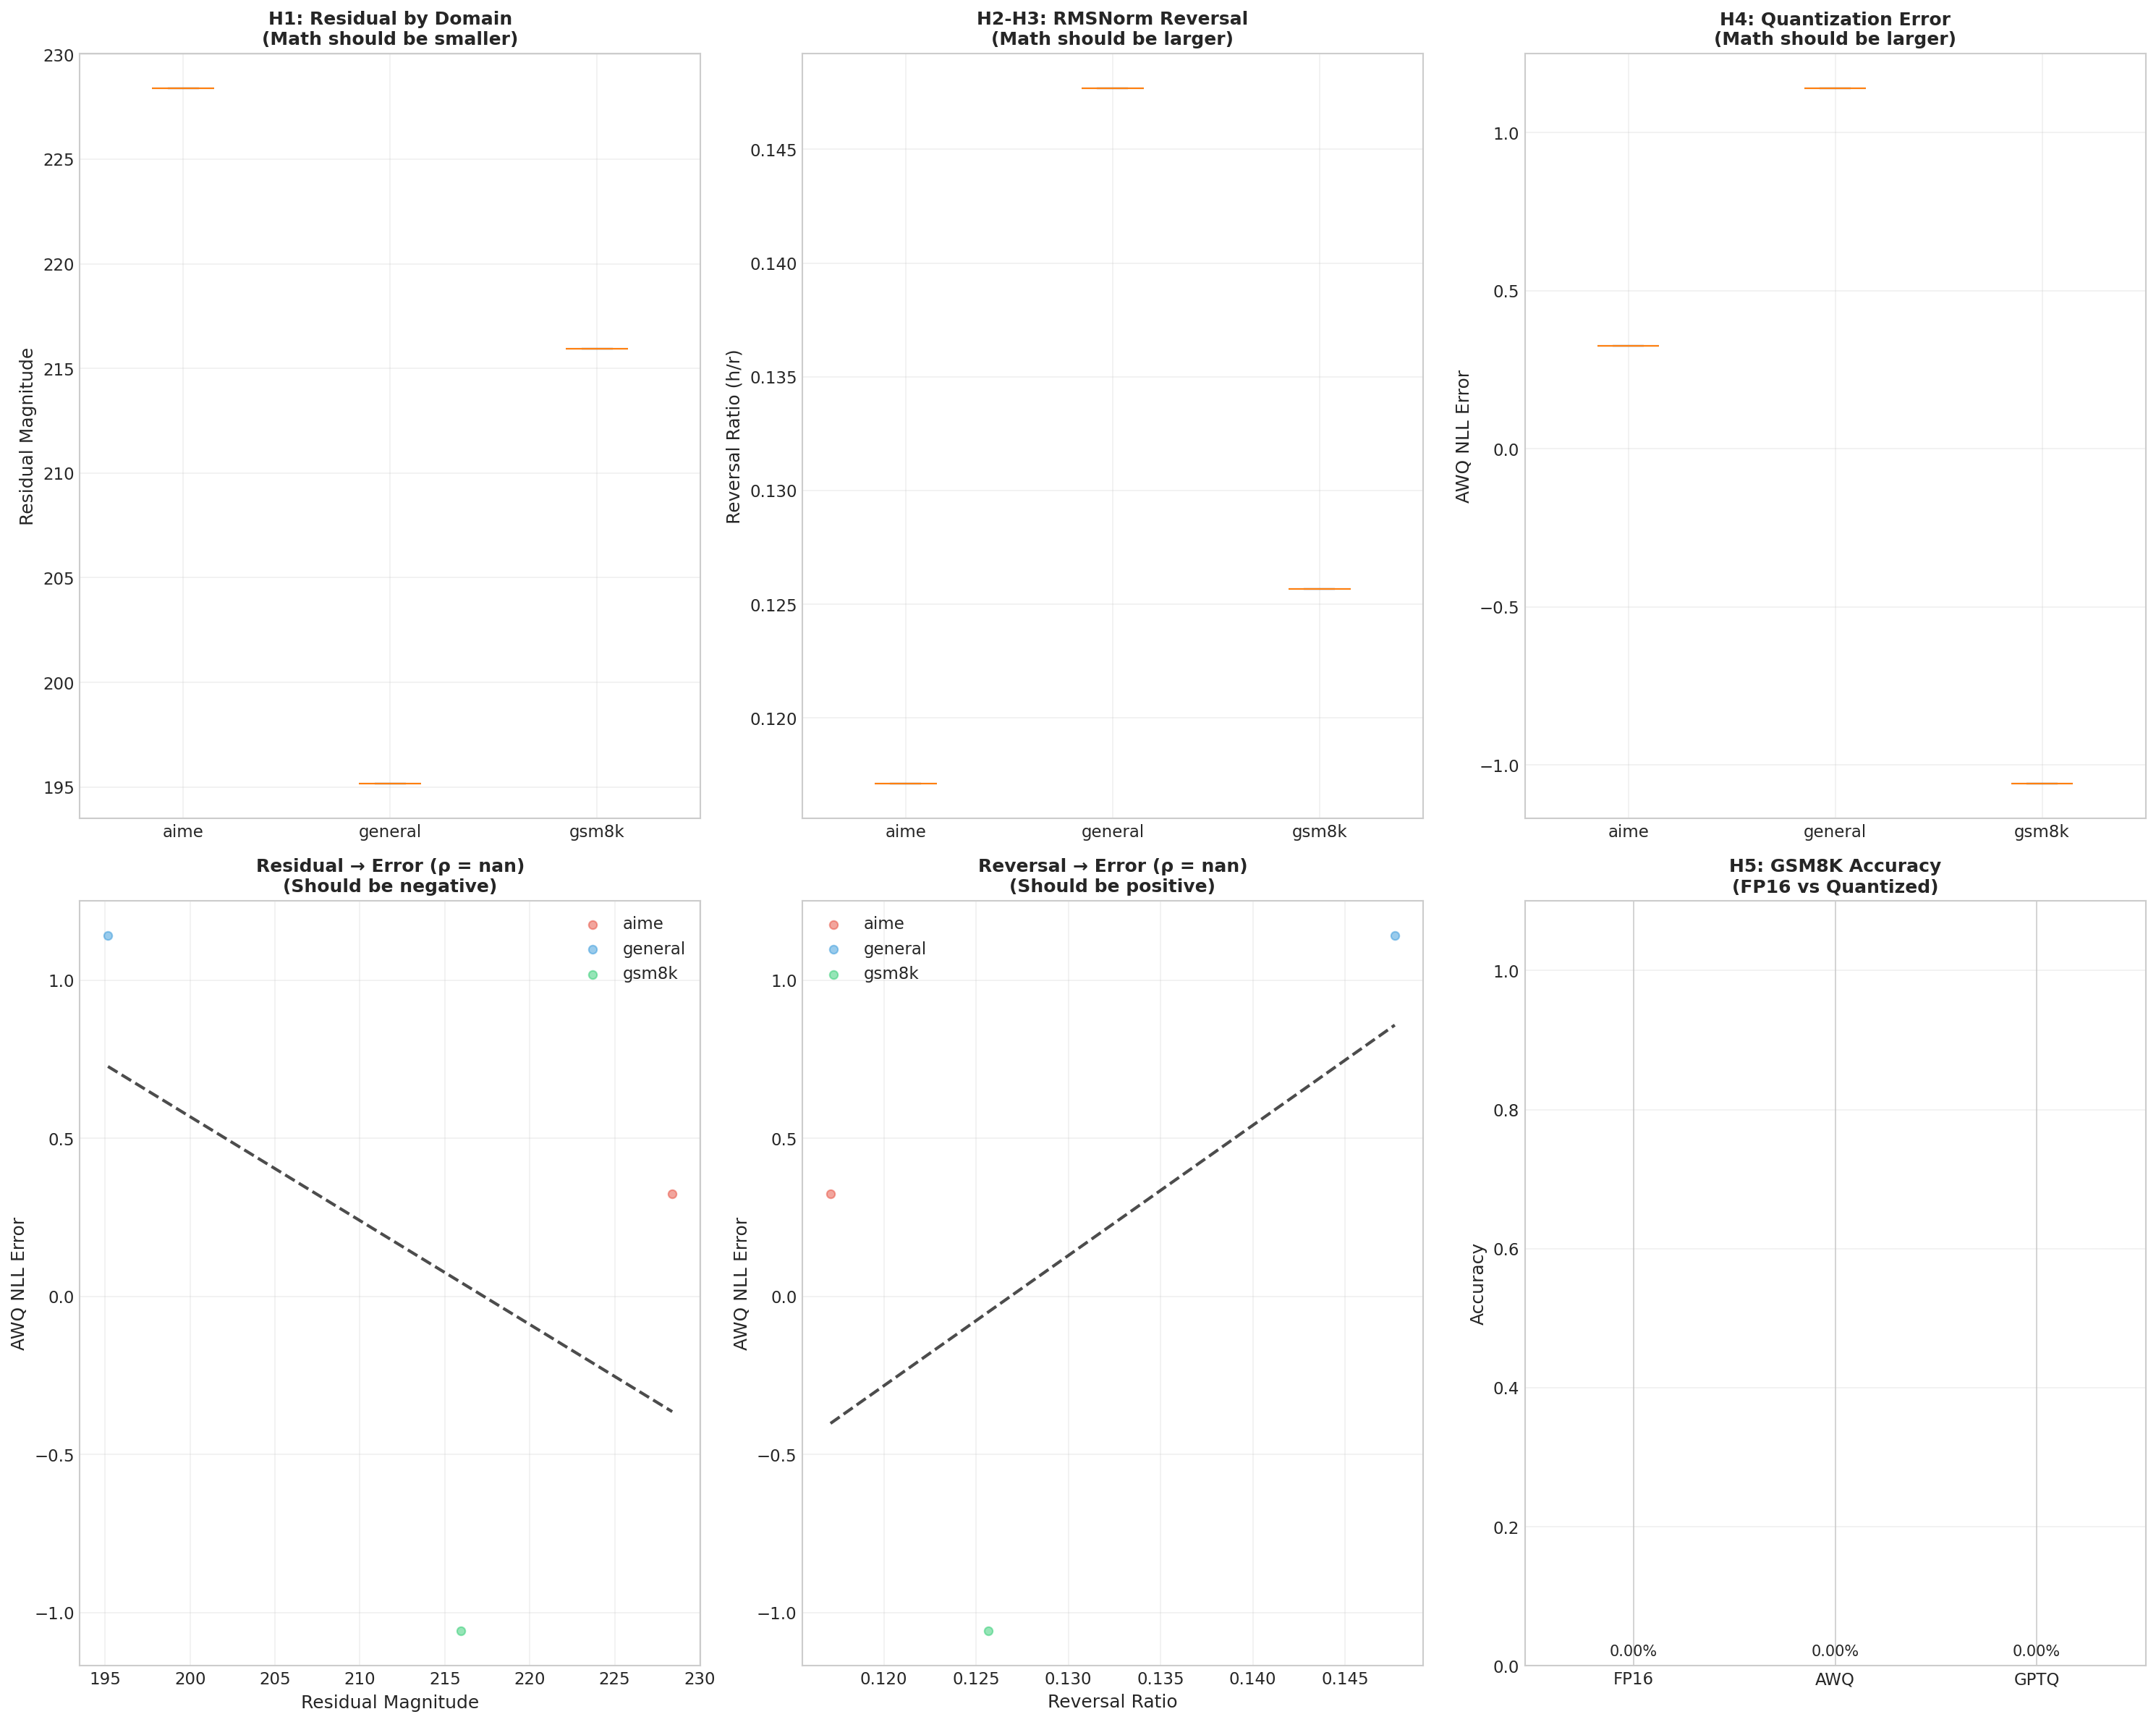

In [15]:
# Create visualizations
fig = create_visualizations(results, ACTIVE_CONFIG)

## 9. Summary Report

In [16]:
def print_summary_report(results: Dict, config: ExperimentConfig):
    """
    Print a comprehensive summary report.
    """
    stats = results['statistics']
    
    print("\n" + "="*80)
    print("MECHANISM CHAIN VERIFICATION: SUMMARY REPORT")
    print("="*80)
    
    print(f"\nModel: {config.base_model}")
    print(f"Quantization: {config.quant_bits}-bit")
    print(f"Total samples: {len(results['mechanism_data'])}")
    
    # Hypothesis testing summary
    print("\n" + "-"*60)
    print("HYPOTHESIS TESTING RESULTS")
    print("-"*60)
    
    # H1: Domain comparison
    domain_p = stats.get('domain_comparison_residual', {}).get('kruskal_wallis', {}).get('p_value', np.nan)
    h1_result = "✓ SUPPORTED" if domain_p < 0.05 else "✗ NOT SUPPORTED"
    print(f"\nH1: Math has smaller residuals than general text")
    print(f"    Kruskal-Wallis p = {domain_p:.2e} → {h1_result}")
    
    # Get correlations
    chain_corr = stats.get('chain_correlations', {})
    
    # H2-H3: Chain correlations
    r_rev = chain_corr.get('residual_to_reversal', {}).get('rho', np.nan)
    r_rev_p = chain_corr.get('residual_to_reversal', {}).get('p_value', np.nan)
    h2_result = "✓ SUPPORTED" if r_rev < -0.1 and r_rev_p < 0.05 else "✗ NOT SUPPORTED"
    print(f"\nH2: Smaller residuals → Stronger reversal")
    print(f"    ρ(Residual, Reversal) = {r_rev:.4f}, p = {r_rev_p:.2e} → {h2_result}")
    
    rev_h = chain_corr.get('reversal_to_hidden', {}).get('rho', np.nan)
    rev_h_p = chain_corr.get('reversal_to_hidden', {}).get('p_value', np.nan)
    h3_result = "✓ SUPPORTED" if rev_h > 0.1 and rev_h_p < 0.05 else "✗ NOT SUPPORTED"
    print(f"\nH3: Stronger reversal → Larger hidden magnitude")
    print(f"    ρ(Reversal, Hidden) = {rev_h:.4f}, p = {rev_h_p:.2e} → {h3_result}")
    
    # H4: For each quantization method
    for key in chain_corr.keys():
        if 'residual_to_error' in key:
            method = key.split('_')[-1]
            r_e = chain_corr[key].get('rho', np.nan)
            r_e_p = chain_corr[key].get('p_value', np.nan)
            h4_result = "✓ SUPPORTED" if r_e < -0.3 and r_e_p < 0.05 else "△ PARTIAL" if r_e < 0 else "✗ NOT SUPPORTED"
            print(f"\nH4 ({method}): Smaller residuals → Larger quantization errors")
            print(f"    ρ(Residual, Error) = {r_e:.4f}, p = {r_e_p:.2e} → {h4_result}")
    
    # H5: Accuracy degradation
    print(f"\nH5: Higher quantization errors → Greater accuracy degradation")
    acc_analysis = stats.get('accuracy_analysis', {})
    for method, data in acc_analysis.items():
        deg = data.get('degradation', 0) * 100
        print(f"    {method}: {data.get('fp16_accuracy', 0):.2%} → {data.get('quant_accuracy', 0):.2%} (↓{deg:.1f}%)")
    
    # Mediation analysis summary
    print("\n" + "-"*60)
    print("MEDIATION ANALYSIS (Causal Chain Evidence)")
    print("-"*60)
    
    med = stats.get('mediation', {})
    for key, data in med.items():
        if 'error' not in data:
            indirect = data.get('indirect_effect', {}).get('coef', np.nan)
            indirect_p = data.get('indirect_effect', {}).get('p_value', np.nan)
            prop_med = data.get('proportion_mediated', np.nan)
            
            print(f"\n{key}:")
            print(f"  Indirect effect: {indirect:.4f} (p = {indirect_p:.2e})")
            print(f"  Proportion mediated: {prop_med:.2%}")
            
            if indirect_p < 0.05:
                print(f"  → Significant mediation detected!")
    
    print("\n" + "="*80)
    print("END OF REPORT")
    print("="*80)

In [17]:
# Print summary report
print_summary_report(results, ACTIVE_CONFIG)


MECHANISM CHAIN VERIFICATION: SUMMARY REPORT

Model: ./modelzoo/DeepSeek-R1/DeepSeek-R1-Distill-Qwen-1.5B
Quantization: 3-bit
Total samples: 3

------------------------------------------------------------
HYPOTHESIS TESTING RESULTS
------------------------------------------------------------

H1: Math has smaller residuals than general text
    Kruskal-Wallis p = 3.68e-01 → ✗ NOT SUPPORTED

H2: Smaller residuals → Stronger reversal
    ρ(Residual, Reversal) = nan, p = nan → ✗ NOT SUPPORTED

H3: Stronger reversal → Larger hidden magnitude
    ρ(Reversal, Hidden) = nan, p = nan → ✗ NOT SUPPORTED

H4 (AWQ): Smaller residuals → Larger quantization errors
    ρ(Residual, Error) = nan, p = nan → ✗ NOT SUPPORTED

H4 (GPTQ): Smaller residuals → Larger quantization errors
    ρ(Residual, Error) = nan, p = nan → ✗ NOT SUPPORTED

H5: Higher quantization errors → Greater accuracy degradation
    AWQ: 0.00% → 0.00% (↓0.0%)
    GPTQ: 0.00% → 0.00% (↓0.0%)

------------------------------------------

In [18]:
# Save all outputs
print(f"\nAll results saved to: {ACTIVE_CONFIG.output_dir}/")
print("Files:")
for f in os.listdir(ACTIVE_CONFIG.output_dir):
    print(f"  - {f}")


All results saved to: ./mechanism_chain_results_test/
Files:
  - mechanism_results.csv
  - results.json
  - mechanism_chain_analysis.png
  - config.json
